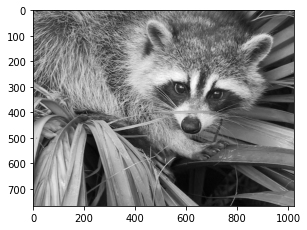

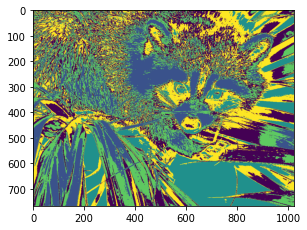


===============================KNN Result==============================



The Initial Entropy : 7.724006175994873
The Final Entropy : 2.2951276302337646







Normalized original photo : 
tensor([[0.4560, 0.5200, 0.5800,  ..., 0.3520, 0.3320, 0.3200],
        [0.4240, 0.4880, 0.5480,  ..., 0.5480, 0.5640, 0.5760],
        [0.5960, 0.6360, 0.6600,  ..., 0.7120, 0.6400, 0.5800],
        ...,
        [0.0280, 0.0280, 0.0320,  ..., 0.0760, 0.0680, 0.0640],
        [0.0760, 0.0800, 0.0880,  ..., 0.1760, 0.1520, 0.1360],
        [0.1520, 0.1360, 0.1440,  ..., 0.5680, 0.5640, 0.5600]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

Normalized Labels : 
tensor([[0.0000, 0.0000, 0.7500,  ..., 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.7500,  ..., 0.7500, 0.7500, 0.7500],
        [0.7500, 0.7500, 0.7500,  ..., 0.2500, 0.7500, 0.7500],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
    

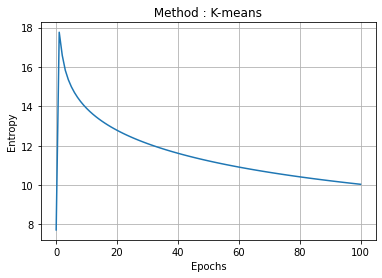

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline
from sklearn.cluster import KMeans
import scipy.misc

#############################################################
# Data
# Visualize the gray scale image before compressing the image

f = scipy.misc.face(gray=True)
plt.figure(figsize=(10, 3.6)) # 가로 세로 인치
###########################print('Image before compression') #
plt.imshow(f, cmap=plt.cm.gray)
plt.show()
#############################################################
# Data Preprocessing
# Get the row and column of the image
rows = f.shape[0]
cols = f.shape[1]
###########################print("rows = {}\n".format(rows))
###########################print("cols = {}\n".format(cols))

# Make it as 1d array
image = f.reshape(rows*cols,1)
###########################print(image)

# Make this 1d array as Tensor
new= []
for i in image:
    for j in i:
        new.append(j)

new_image = torch.tensor(new,dtype=torch.float64, requires_grad=True)

# 전체 tensor 요소 개수 세기
num = 0
for i in new_image:
    num += 1
###########################print("The total # of elements in image : {}".format(num))
#############################################################
class EntropyLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx, activityMatrix):

        #print("==========normalization phase==========")
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        
        
        num = 0
        for i in activityMatrix:
            num += 1

        #normalized_tensor = 63*(activityMatrix - min)/(max-min)
        normalized_tensor = (num-1)*(activityMatrix - min)/(max-min)
        normalized_tensor = torch.round(normalized_tensor)
        normalized_tensor = normalized_tensor.to(int)

        #################################################
        #print("============finished calculating entropy")
        norm_bincounts = torch.bincount(normalized_tensor)
        pixel_num = activityMatrix.shape[0] # test if shape is right
        prob_bincounts = torch.true_divide(norm_bincounts, pixel_num)
        log_bincounts = torch.log2(prob_bincounts) 
        entropyMatrix = log_bincounts*prob_bincounts
        entropyMatrix[entropyMatrix != entropyMatrix] = 0 # no nan.
        entropyMatrix = -1 * entropyMatrix
        entropy = torch.sum(entropyMatrix)
        
        ctx.save_for_backward(activityMatrix, norm_bincounts, log_bincounts)

        return entropy

    def backward(ctx, grad_output):
        activityMatrix, norm_bincounts, log_bincounts,  = ctx.saved_tensors
        dp = log_bincounts - np.log(2)
        df = log_bincounts.clone()
        pixel_num = activityMatrix.shape[0]
        #print("log bincounts:",dp)
        for i in range(norm_bincounts.shape[0]):
            if i == 0:
                df[0] = torch.true_divide(norm_bincounts[0], pixel_num)
            else:
                df[i] = (df[i] - df[i-1])/pixel_num
        #df[df != df] = 0
        #df[df == '-inf'] = 0
        #df[df == 'inf'] = 0
        #print("dp:",dp)
        #print("df: ",df)
        #dnorm = torch.bincount(df)
        
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        dnorm = 63/(max-min)
        #print(dnorm)
        temp = dp*df*dnorm
        #print(temp)
        grad_input = grad_output/temp
        grad_input[grad_input != grad_input] = 0
        #print(grad_input)
        #grad_input = 64*(grad_input)/min   

        return grad_input #dimension이 activityMatrix 맞기만 하면 됨

##############################################
# Compression K-MEANS

# Compressing the gray scale image into 5 clusters
# Use KNN to fit the image
kmeans = KMeans(n_clusters = 5)
new_new_image = new_image.detach().numpy()
new_new_image=new_new_image.reshape(-1, 1)
kmeans.fit(new_new_image)

# Get the cluster and the labels for the image
clusters = np.asarray(kmeans.cluster_centers_) 
labels = np.asarray(kmeans.labels_)
###########################print("***************")
###########################print("Label result = ", labels)
###########################print("***************")

# Reshape the label as matrix
labels = labels.reshape(rows,cols); 
###########################print("Reshaping labels = ",labels)
###########################print("***************")
#Save the compressed image
plt.imsave('compress_racoon.png',labels);

# Visualize the compressed image
###########################print('Image after compression')
image = plt.imread('compress_racoon.png')
plt.figure(figsize=(10, 3.6))
plt.imshow(image)
plt.show()

##############################################
### First Entropy
losses = []
first = EntropyLoss.apply(new_image) # first entropy 넣기
losses.append(first.item())

### Last Entropy
labels_new = []
for i in labels:
    for j in i:
        labels_new.append(j)
###########################print("Preprocessing has been finished!!!")
new_labels = torch.tensor(labels_new,dtype=torch.float64, requires_grad=True )
labels_reshape = new_labels.view(-1,64)
images_reshape = new_image.view(-1,64)
###########################print("Reshape the images : ", images_reshape.shape) # backward때문에 reshape
###########################print("Reshape the labels : ", labels_reshape.shape) # backward때문에 reshape

last = EntropyLoss.apply(new_labels)
losses.append(last.item())

print("\n===============================KNN Result==============================\n")

print("\n\nThe Initial Entropy : {}".format(losses[0]))
print("The Final Entropy : {}\n".format(losses[-1]))

print("\n\n=====================================================================\n")



################################################################################
# 여기까지는 단순 KNN 돌린 후 Entropy 결과 차이 확인한 것
################################################################################

# Fully Connected Layer
### Settings - 1
model = nn.Sequential(nn.Linear(64,64))
optimizer = optim.Adam(model.parameters(),lr=0.1)

# First Entropy
new_losses = []
temp = images_reshape.view(-1,)
first = EntropyLoss.apply(temp.float()) # first entropy 넣기
new_losses.append(first.item())

###########################print("\n\nML First Entropy : ", new_losses[0])
print("\n\n")

## Normalizing function (Min-Max Normalization)
def nor(matrix):
    max = torch.max(matrix)
    min = torch.min(matrix)
    normalized_tensor = (matrix - min)/(max-min)
    return normalized_tensor

# Parameter Preprocessing
images_reshape = nor(images_reshape)
print("Normalized original photo : \n{}\n".format(images_reshape))
nor_labels = nor(labels_reshape)
print("Normalized Labels : \n{}\n".format(nor_labels))

# Epochs
epochs = 100
for epoch in range(epochs):

  # Construction
  y_pred = model(images_reshape.float()) # forward 연산 #images_reshape는 원본이미지
  
  lossi = (y_pred-images_reshape)
  #
  n_loss = lossi.view(-1,)

  y_pred = y_pred.view(-1,) #entropyloss 함수는 1-D Dimension만 돼서
  loss = EntropyLoss.apply(n_loss) # Mean Absolute Error Loss
  optimizer.zero_grad() # Gradient Descent 하기 전 gradient 0으로 설정
  
  entropy = EntropyLoss.apply(y_pred.float()) # 일시적으로 바꾼 값을 넣는다
  
  #
  loss.backward(retain_graph=True) # backpropagation
  optimizer.step() # model의 parameter들을 update 

  if epoch % (epochs/10) == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, loss.item()
        ))
    print('   - pred_y : \n{} \n'.format(y_pred))
    print('   - Labels : \n{} \n'.format(labels_reshape))
    print("\n")

  new_losses.append(entropy.item())

#############################################

print("\n===========================FC Layer Result==============================\n")

print("\n\nThe Initial Entropy : {}".format(new_losses[0]))
print("The Final Entropy : {}\n".format(new_losses[-1]))

print("\n\n=====================================================================\n")
#############################################

method = "K-means"
plt.title(" Method : {} ".format(method))
plt.plot(new_losses)
plt.xlabel("Epochs")
plt.ylabel("Entropy")
plt.grid(True)

